# Bibliotecas



In [ ]:
%tensorflow_version 2.x
import json
import requests
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error
%matplotlib inline

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


# Dados
Alterado o parametro do fsym de acordo com a criptomoeda deseja, seguindo as conformidades especificadas no API Cryptocompare.com

A parâmetro limite refere as ultimas cotações, a contar da data que está rodando a API. O limite de dados está especificado na página "https://min-api.cryptocompare.com/documentation?key=Blockchain&cat=blockchainListOfCoins&api_key=1e5169889bcb29a6ec3fc5d4d4f72348d1cbe67d9bd018a7bdef64e8e61408e2"

é necessário criar um chave primária para consulta

In [ ]:
endpoint = 'https://min-api.cryptocompare.com/data/histoday'
res = requests.get(endpoint + '?fsym=DOGE&tsym=CAD&limit=2000')
hist = pd.DataFrame(json.loads(res.content)['Data'])
hist = hist.set_index('time')
hist.index = pd.to_datetime(hist.index, unit='s')
target_col = 'close'

In [ ]:
hist.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2001 entries, 2017-10-06 to 2023-03-29
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   high              2001 non-null   float64
 1   low               2001 non-null   float64
 2   open              2001 non-null   float64
 3   volumefrom        2001 non-null   float64
 4   volumeto          2001 non-null   float64
 5   close             2001 non-null   float64
 6   conversionType    2001 non-null   object 
 7   conversionSymbol  2001 non-null   object 
dtypes: float64(6), object(2)
memory usage: 140.7+ KB


In [ ]:
hist.drop(["conversionType", "conversionSymbol"], axis = 'columns', inplace = True)

In [ ]:
hist.head(5)

,high,low,open,volumefrom,volumeto,close
time,,,,,,
2017-10-06,0.001461,0.001214,0.001159,136191.20,179.73,0.001320
2017-10-07,0.001392,0.001257,0.001320,397572.83,521.71,0.001312
2017-10-08,0.001535,0.001123,0.001312,589277.91,819.70,0.001391
2017-10-09,0.001327,0.001179,0.001391,262074.16,345.72,0.001319
2017-10-10,0.001357,0.001222,0.001319,159924.02,211.47,0.001322


In [ ]:
hist.head(-5)

,high,low,open,volumefrom,volumeto,close
time,,,,,,
2017-10-06,0.001461,0.001214,0.001159,136191.20,179.73,0.001320
2017-10-07,0.001392,0.001257,0.001320,397572.83,521.71,0.001312
2017-10-08,0.001535,0.001123,0.001312,589277.91,819.70,0.001391
2017-10-09,0.001327,0.001179,0.001391,262074.16,345.72,0.001319
2017-10-10,0.001357,0.001222,0.001319,159924.02,211.47,0.001322
...,...,...,...,...,...,...
2023-03-20,0.104800,0.095970,0.102900,35044040.55,3426541.84,0.097780
2023-03-21,0.109500,0.100900,0.097780,36920533.00,3884582.86,0.105200
2023-03-22,0.103100,0.098770,0.105200,42002908.26,4262922.92,0.101500


In [ ]:
def div_test_treino(df, test_size=0.2):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data

In [ ]:
train, test = div_test_treino(hist, test_size=0.2)

In [ ]:
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(15, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('preço (Dogecoin)', fontsize=16)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=18);

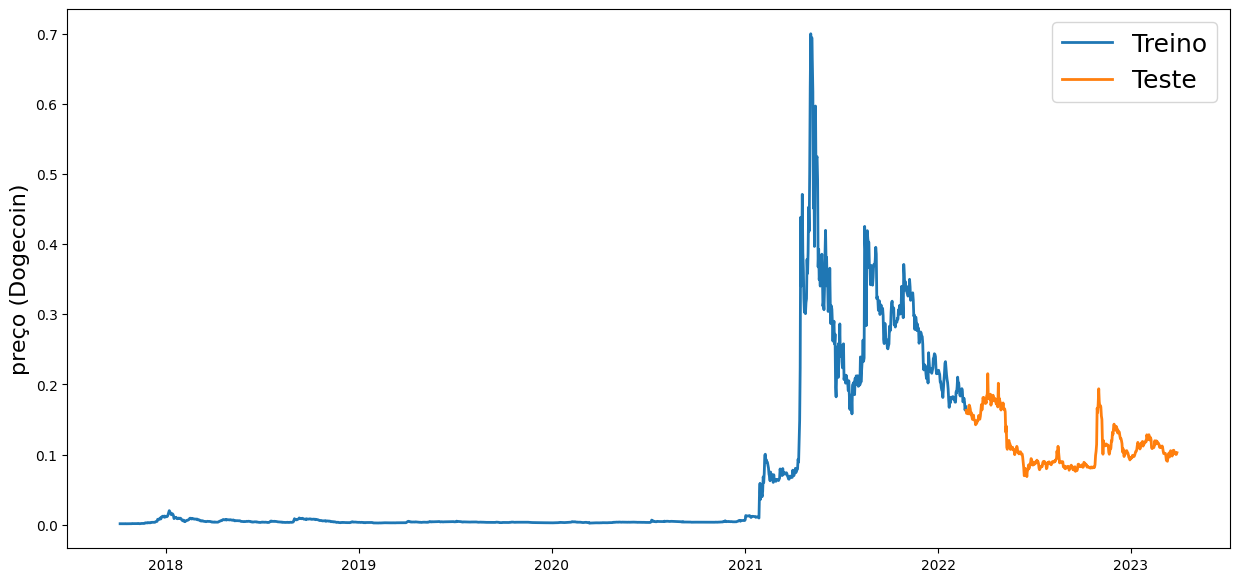

In [ ]:
line_plot(train[target_col], test[target_col], 'Treino', 'Teste', title='' )

# Normalização de dados apartir da baze 0

In [ ]:
def normalise_zero_base(df):
    return df / df.iloc[0] - 1

def normalise_min_max(df):
    return (df - df.min()) / (data.max() - df.min())

# Converter as janelas sobrepostas para base Zero

In [ ]:
def Extrair_janela(df, janelas=5, zero_base=True):
    window_data = []
    for idx in range(len(df) - janelas):
        tmp = df[idx: (idx + janelas)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)

# Preparar os dados para a estrutura do LSTM

In [ ]:
def preparar_data(df, target_col, janelas=7, zero_base=True, test_size=0.2):
    train_data, test_data = div_test_treino(df, test_size=test_size)
    X_train = Extrair_janela(train_data, janelas, zero_base)
    X_test = Extrair_janela(test_data, janelas, zero_base)
    y_train = train_data[target_col][janelas:].values
    y_test = test_data[target_col][janelas:].values
    if zero_base:
        y_train = y_train / train_data[target_col][:-janelas].values - 1
        y_test = y_test / test_data[target_col][:-janelas].values - 1

    return train_data, test_data, X_train, X_test, y_train, y_test

# Criar modelo LSTM
Altere a parametro "neurons" de acordo com o neurónio deseja
Matenha a camada de Dropunt em 20%

In [ ]:
def Arquitetura_lstm(input_data, output_size, neurons=70, activ_func='linear',
                     dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

In [ ]:
np.random.seed(32)
janelas = 7
test_size = 0.2
zero_base = True
lstm_neurons = 70
epocas = 45
batch_size = 32
loss = 'mse'
dropout = 0.2
optimizer = 'adam'

In [ ]:
train, test, X_train, X_test, y_train, y_test = preparar_data(hist, target_col, janelas=janelas, zero_base=zero_base, test_size=test_size)

In [ ]:
model = Arquitetura_lstm (
    X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)
history = model.fit(
    X_train, y_train, validation_data=(X_test, y_test), epochs=epocas, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/45
50/50 [==============================] - 6s 27ms/step - loss: 0.0842 - val_loss: 0.0071
Epoch 2/45
50/50 [==============================] - 1s 10ms/step - loss: 0.0537 - val_loss: 0.0060
Epoch 3/45
50/50 [==============================] - 0s 8ms/step - loss: 0.0415 - val_loss: 0.0055
Epoch 4/45
50/50 [==============================] - 0s 7ms/step - loss: 0.0348 - val_loss: 0.0060
Epoch 5/45
50/50 [==============================] - 0s 5ms/step - loss: 0.0351 - val_loss: 0.0050
Epoch 6/45
50/50 [==============================] - 0s 5ms/step - loss: 0.0355 - val_loss: 0.0053
Epoch 7/45
50/50 [==============================] - 0s 6ms/step - loss: 0.0307 - val_loss: 0.0042
Epoch 8/45
50/50 [==============================] - 0s 5ms/step - loss: 0.0317 - val_loss: 0.0038
Epoch 9/45
50/50 [==============================] - 0s 6ms/step - loss: 0.0292 - val_loss: 0.0046
Epoch 10/45
50/50 [==============================] - 0s 5ms/step - loss: 0.0298 - val_loss: 0.0044
Epoch 11/45
50/50

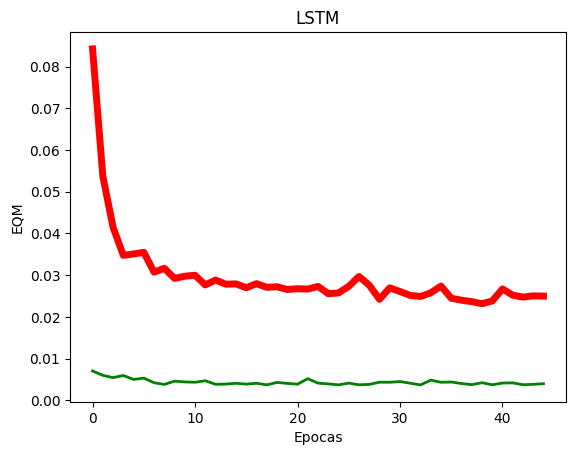

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'],'r',linewidth=5, label='Train loss')
plt.plot(history.history['val_loss'], 'g',linewidth=2, label='Validation loss')
plt.title('LSTM')
plt.xlabel('Epocas')
plt.ylabel('EQM')
plt.show()

In [ ]:
targets = test[target_col][janelas:]
preds = model.predict(X_test).squeeze()
mean_absolute_error(preds, y_test)

13/13 [==============================] - 0s 2ms/step


0.04012863337408467

In [ ]:
from sklearn.metrics import mean_squared_error
MAE=mean_squared_error(preds, y_test)
MAE

0.003995743534687855

In [ ]:
from sklearn.metrics import r2_score
R2=r2_score(y_test, preds)
R2

0.8559528297487339

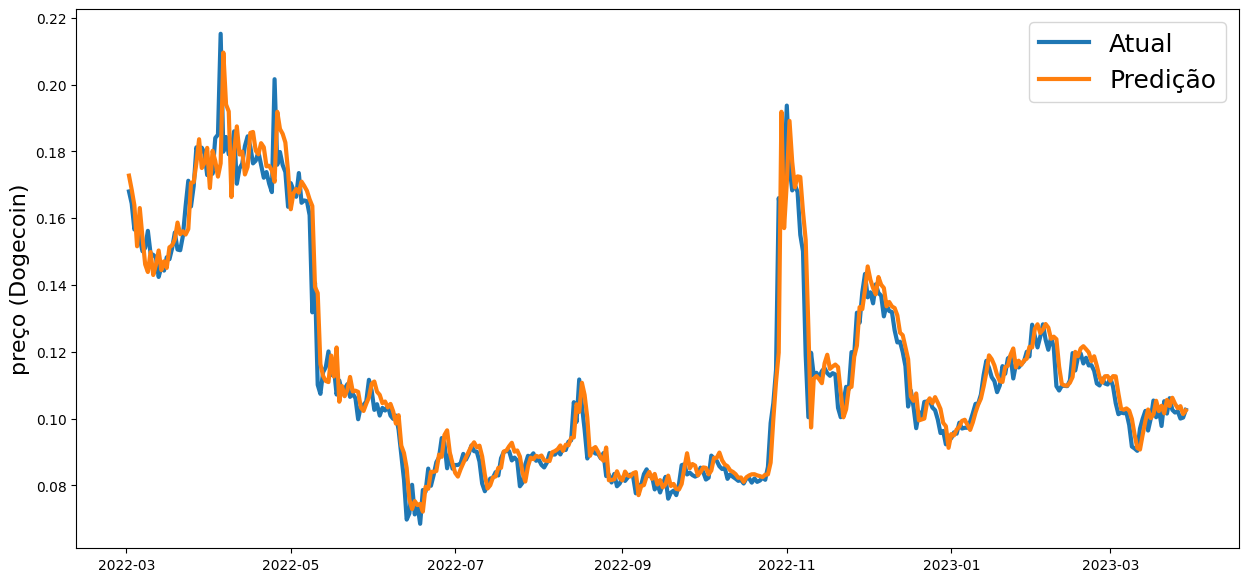

In [ ]:
preds = test[target_col].values[:-janelas] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)
line_plot(targets, preds, 'Atual', 'Predição', lw=3)